# **[HW5] Language Model**
1. DataLoader
2. Model
3. Trainer
4. Generation

이번 실습에서는 RNN기반의 Language Model를 구현해서 텍스트를 직접 생성해보는 실습을 진행해보겠습니다.

- dataset: WikiText2 (https://github.com/pytorch/examples/tree/master/word_language_model/data/wikitext-2)
- model: LSTM




## Import packages

런타임의 유형을 변경해줍니다.

상단 메뉴에서 [런타임]->[런타임유형변경]->[하드웨어가속기]->[GPU]

변경 이후 아래의 cell을 실행 시켰을 때, torch.cuda.is_avialable()이 True가 나와야 합니다.



In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
print(torch.__version__)
print(torch.cuda.is_available())

1.12.1+cu113
True


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tqdm
import os
import random
import time
import datetime

# for reproducibility
random.seed(1234)
np.random.seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. DataLoader

이전의 실습들에서 사용한것과 마찬가지로, PyTorch style의 dataloader를 먼저 만들어 두겠습니다.

### Dataset

저희가 이번 실습에서 사용할 데이터셋은 Wikipedia에 있는 영문 글들을 가져온 WikiTree dataset입니다.
저희가 불러올 데이터는 가장 작은 WikiTree dataset에서 자주 사용되지 않는 단어나 영어가 아닌 단어들은 <unk>으로 이미 전처리가 되어있습니다.

In [32]:
import urllib
with urllib.request.urlopen('https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/02-intermediate/language_model/data/train.txt') as f:
    data = f.readlines()

In [33]:
print('num_sentence:',len(data))
data[100]

num_sentence: 42068


b" plans that give advertisers discounts for maintaining or increasing ad spending have become permanent <unk> at the news <unk> and underscore the fierce competition between newsweek time warner inc. 's time magazine and <unk> b. <unk> 's u.s. news & world report \n"

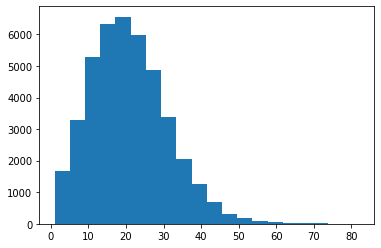

In [34]:
seq_length_list = []
for line in data:
    seq_length_list.append(len(line.split()))

counts, bins = np.histogram(seq_length_list, bins=20)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

데이터에 있는 문장 길이들의 histogram을 볼 때 대부분의 data의 문장 길이가 50에 미치지 못하기 때문에 \\
model에 집어넣을 최대 문장 길이를 50으로 세팅해두도록 하겠습니다.

In [35]:
max_seq_len = 50

### Build Dictionary

먼저 text 데이터를 모델에 넣어주기 위해서는 text에 존재하는 단어들을 index로 변환해주어야 합니다.

이를 위해서는 단어를 index로 변환해주는 word2idx dictionary와 다시 index를 단어로 변환해주는 idx2word dictionary를 만들어야 합니다.


In [36]:
def build_dictionary(data, max_seq_len):
    word2idx = {}
    idx2word = {}
    ## Build Dictionary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    idx2word[0] = '<pad>'
    idx2word[1] = '<unk>'
    idx = 2
    for line in data:
        words = line.decode('utf-8').split()
        words = words[:max_seq_len]        
        ### Build Dictionary to convert word to index and index to word
        ### YOUR CODE HERE (~ 5 lines)
        for word in words:
            if word not in word2idx:
                word2idx[word] = idx
                idx2word[idx] = word
                idx += 1
        #데이터를 순회하면서 사전에 없는 단어를 새로 추가합니다.
        #word -> index, index -> word 둘다 빠르게 인덱싱할 수 있도록 따로 딕셔너리형태로 만듭니다.
    return word2idx, idx2word

word2idx, idx2word = build_dictionary(data, max_seq_len)

In [37]:
if len(word2idx) == len(idx2word) == 10000:
    print("Test Passed!")
else:
    raise AssertionError

Test Passed!


### Preprocessing

이제 앞서 만든 dictionary를 이용해서 text로된 데이터셋을 index들로 변환시키겠습니다.

In [38]:
def preprocess(data, word2idx, idx2word, max_seq_len):
    tokens = []
    for line in data:
        words = line.decode('utf-8').split()
        words = words[:max_seq_len]
        ### Convert dataset with tokens
        ### For each line, append <pad> token to match the number of max_seq_len
        ### YOUR CODE HERE (~ 4 lines)
        words += ["<pad>"] * (max_seq_len - len(words))
        #words = ["<pad>"] * (max_seq_len - len(words)) + words ??
        for word in words:
            token = word2idx[word]
            tokens.append(token)
        #필요한 만큼 패딩을 뒤에다 더합니다.
        #tokens 배열에 단어를 인덱스로 변환해서 해당 자리에 인덱스를 넣어줍니다.
        
    return tokens

tokens = preprocess(data, word2idx, idx2word, max_seq_len)

In [39]:
if len(tokens) == 2103400: #???
    print("Test Passed!")
else:
    raise AssertionError

Test Passed!


이제 전처리된 Token들을 문장 단위의 배열로 변환시켜 두겠습니다.

In [40]:
tokens = np.array(tokens).reshape(-1, max_seq_len)
print(tokens.shape)
tokens[100]

(42068, 50)


array([745,  93, 746, 739, 747, 181, 748, 467, 749, 740, 750, 154, 751,
       752,   1, 160,  32, 753,   1,  48, 754,  32, 755, 756, 757, 728,
       555, 758,  99, 119, 555, 733,  48,   1, 759,   1, 119, 237, 753,
       230, 760, 347,   0,   0,   0,   0,   0,   0,   0,   0])

### DataLoader

이제 전처리된 dataset을 활용하여 PyTorch style의 dataset과 dataloader를 만들도록 하겠습니다.

Token형태의 데이터를 PyTorch 스타일의 dataset으로 만들 때 주의할 점은, 추후 embedding matrix에서 indexing을 해주기 위해서 각 token이 LongTensor 형태로 정의되어야 한다는 점입니다.

In [41]:
class LMDataset(torch.utils.data.Dataset):
    def __init__(self, tokens):
        super(LMDataset, self).__init__()
        self.PAD = 0
        self.UNK = 1
        self.tokens = tokens
        self._getitem(2)

    def _getitem(self, index):
        X = self.tokens[index]
        y = np.concatenate((X[1:], [self.PAD]))

        X = torch.from_numpy(X).unsqueeze(0).long()
        y = torch.from_numpy(y).unsqueeze(0).long()

        return X, y

    def __getitem__(self, index):
        X = self.tokens[index]
        y = np.concatenate((X[1:], [self.PAD]))

        X = torch.from_numpy(X).long()
        y = torch.from_numpy(y).long()

        return X, y

    def __len__(self):
        return len(self.tokens)

In [42]:
batch_size = 64
dataset = LMDataset(tokens)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(len(dataset))
print(len(dataloader))

42068
658


# 2. Model

이번 section에서는 Language Modeling을 위한 Recurrent Model을 직접 만들어보도록 하겠습니다.

Standard한 Recurrent Neural Network (RNN) model은 vanishing gradient 문제에 취약하기 때문에, 이번 실습에서는 변형된 RNN구조인 LSTM model을 활용하도록 하겠습니다.


### LSTM

LSTM model의 전체적인 구조와 각 gate의 수식은 아래와 같습니다.

![](https://drive.google.com/uc?export=view&id=1n93tpNW55Xl4GxZNcJcbUVRhuNCGH38h)

![](https://drive.google.com/uc?export=view&id=1nH9U5iD9cO6OVVTbrx-LjypRvcWzbOCU)

LSTM의 자세한 동작방식이 궁금하신 분은 아래의 블로그를 참조해주세요.

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [43]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        # input-gate
        self.Wi = nn.Linear(input_size + hidden_size, hidden_size)
        # forget-gate
        self.Wf = nn.Linear(input_size + hidden_size, hidden_size)
        # gate-gate
        self.Wg = nn.Linear(input_size + hidden_size, hidden_size)
        # output-gate
        self.Wo = nn.Linear(input_size + hidden_size, hidden_size)

        # non-linearity
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, h_0, c_0):
        """
        Inputs
            input (x): [batch_size, input_size]
            hidden_state (h_0): [batch_size, hidden_size]
            cell_state (c_0): [batch_size, hidden_size]
        Outputs
            next_hidden_state (h_1): [batch_size, hidden_size]
            next_cell_state (c_1): [batch_size, hidden_size]    
        """
        h_1, c_1 = None, None
        input = torch.cat((x, h_0), 1)     #이전 셀의 출력과 이번 셀의 입력이 입력으로 주어짐짐
        # Implement LSTM cell as noted above
        ### YOUR CODE HERE (~ 6 lines)
        i = self.sigmoid(self.Wi(input))   #tanh 활성화 함수를 통과한 값과 곱해짐.
        f = self.sigmoid(self.Wf(input))   #이전 셀의 c_0와 곱해짐.
        g = self.tanh(self.Wg(input))      #
        o = self.sigmoid(self.Wo(input))   #tanh를 통과한 c_1값과 곱해져서 결과가 곱해져서 h_1이 됨.
        c_1 = f * c_0 + i* g
        h_1 = o * self.tanh(c_1)
        return h_1,c_1


In [44]:
def test_lstm():
    batch_size = 2
    input_size = 5
    hidden_size = 3

    #torch.manual_seed(1234)
    lstm = LSTMCell(input_size ,hidden_size)
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.constant_(m.weight, 0.1)
            m.bias.data.fill_(0.01)
    lstm.apply(init_weights)

    x = torch.ones(batch_size, input_size) 
    hx = torch.zeros(batch_size, hidden_size) 
    cx = torch.zeros(batch_size, hidden_size)

    hx, cx = lstm(x, hx, cx)
    assert hx.detach().allclose(torch.tensor([[0.1784, 0.1784, 0.1784], 
                                              [0.1784, 0.1784, 0.1784]]), atol=2e-1), \
            f"Output of the hidden state does not match."
    assert cx.detach().allclose(torch.tensor([[0.2936, 0.2936, 0.2936], 
                                              [0.2936, 0.2936, 0.2936]]), atol=2e-1), \
            f"Output of the cell state does not match."

    print("==LSTM cell test passed!==")

test_lstm()

==LSTM cell test passed!==


## Language Model

이제, 위에서 정의한 LSTM Cell을 활용해서 아래와 같은 Langauge Model을 만들어보도록 하겠습니다.


![](https://drive.google.com/uc?export=view&id=1nMAbL-g31nERM44dgohA3k9Vj_92hIh-)

In [45]:
class LanguageModel(nn.Module):
    def __init__(self, input_size=64, hidden_size=64, vocab_size=10000):
        super(LanguageModel, self).__init__()
        
        self.input_layer = nn.Embedding(vocab_size, input_size)
        self.hidden_layer = LSTMCell(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, vocab_size)


    def forward(self, x, hx, cx, predict=False):
        """
        Inputs
            input (x): [batch_size]
            hidden_state (h_0): [batch_size, hidden_size]
            cell_state (c_0): [batch_size, hidden_size]
            predict: whether to predict and sample the next word
        Outputs
            output (ox): [batch_size, hidden_size]
            next_hidden_state (h_1): [batch_size, hidden_size]
            next_cell_state (c_1): [batch_size, hidden_size]    
        """
        x = self.input_layer(x)
        hx, cx = self.hidden_layer(x, hx, cx)
        ox = self.output_layer(hx)

        if predict == True:
            probs = F.softmax(ox, dim=1)
            # torch distribution allows sampling operation
            # see https://pytorch.org/docs/stable/distributions.html
            dist = torch.distributions.Categorical(probs)
            ox = dist.sample()

        return ox, hx, cx  

# 3. Trainer

자 이제 위에서 구현한 dataloader와 langauge model을 활용해서 모델의 학습을 진행해보도록 하겠습니다.


In [46]:
class Trainer():
    def __init__(self, 
                 word2idx, 
                 idx2word,
                 dataloader, 
                 model, 
                 criterion,
                 optimizer, 
                 device):
        """
        dataloader: dataloader
        model: langauge model
        criterion: loss function to evaluate the model (e.g., BCE Loss)
        optimizer: optimizer for model
        """
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.dataloader = dataloader
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        
    def train(self, epochs = 1):
        self.model.to(self.device)
        start_time = time.time()
        for epoch in range(epochs):
            losses = []
            for iter, (x_batch, y_batch) in tqdm.tqdm(enumerate(self.dataloader)):
                self.model.train()
                
                batch_size, max_seq_len = x_batch.shape
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                # initial hidden-states
                hx = torch.zeros(batch_size, hidden_size).to(self.device)
                cx = torch.zeros(batch_size, hidden_size).to(self.device)

                # Implement LSTM operation
                ox_batch = []
                # Get output logits for each time sequence and append to the list, ox_batch
                # YOUR CODE HERE (~ 4 lines)
                for s_idx in range(max_seq_len):
                    x=x_batch[:, s_idx]
                    ox,hx,cx = self.model(x,hx,cx)
                    ox_batch.append(ox)

                # outputs are ordered by the time sequence
                ox_batch = torch.cat(ox_batch).reshape(max_seq_len, batch_size, -1)
                ox_batch = ox_batch.permute(1,0,2).reshape(batch_size*max_seq_len, -1)
                y_batch = y_batch.reshape(-1)

                self.model.zero_grad()
                loss = self.criterion(ox_batch, y_batch)
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())

            end_time = time.time() - start_time
            end_time = str(datetime.timedelta(seconds=end_time))[:-7]
            print('Time [%s], Epoch [%d/%d], loss: %.4f'
                  % (end_time, epoch+1, epochs, np.mean(losses)))
            if epoch % 5 == 0:
                generated_sentences = self.test()
                print('[Generated Sentences]')
                for sentence in generated_sentences:
                    print(sentence)
            
    def test(self):
        # Test model to genereate the sentences
        self.model.eval()
        num_sentence = 5
        max_seq_len = 50

        # initial hidden-states
        outs = []
        x = torch.randint(0, 10000, (num_sentence,)).to(self.device)
        hx = torch.zeros(num_sentence, hidden_size).to(self.device)
        cx = torch.zeros(num_sentence, hidden_size).to(self.device)

        outs.append(x)
        with torch.no_grad():
            for s_idx in range(max_seq_len-1):
                x, hx, cx = self.model(x, hx, cx, predict=True)
                outs.append(x)
        outs = torch.cat(outs).reshape(max_seq_len, num_sentence)
        outs = outs.permute(1, 0)
        outs = outs.detach().cpu().numpy()

        sentences = []
        for out in outs:
            sentence = []
            for token_idx in out:
                word = self.idx2word[token_idx]
                sentence.append(word)
            sentences.append(sentence)
       
        return sentences

In [47]:
for iter,(x_batch,y_batch) in (enumerate(dataloader)):
    print(x_batch.shape)

torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([6

In [48]:
lr = 1e-2
input_size = 128
hidden_size = 128
batch_size = 256

dataset = LMDataset(tokens)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = LanguageModel(input_size=input_size, hidden_size=hidden_size)
# NOTE: you should use ignore_index to ignore the loss from predicting the <PAD> token
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device('cuda')

trainer = Trainer(word2idx = word2idx,
                  idx2word = idx2word,
                  dataloader=dataloader, 
                  model = model,
                  criterion=criterion,
                  optimizer = optimizer,
                  device=device)

trainer.train(epochs=50)

165it [00:12, 13.48it/s]


Time [0:00:12], Epoch [1/50], loss: 6.0501
[Generated Sentences]
['careful', 'assurances', 'marks', 'trading', 'four', 'would', 'be', 'read', 'would', 'begin', 'unchanged', 'during', 'that', 'first', 'boston', 'said', 'the', 'company', "'s", 'strong', 'first', '<unk>', 'of', 'european', 'is', 'another', '<unk>', 'and', 'absence', 'securities', 'says', 'sen.', 'baskets', "'s", '<unk>', '<unk>', 'already', 'and', 'marcos', 'cbs', 'ca', "n't", 'all', 'lending', 'an', 'ability', 'to', 'be', 'valued', 'to']
['serves', 'operating', 'point', 'on', 'bid', 'projects', 'programs', 'by', 'the', '<unk>', 'and', 'said', 'they', 'expect', 'the', 'interest', 'rates', 'in', 'a', 'past', 'step', 'on', 'make', 'service', 'of', 'the', 'press', 'which', 'rose', 'slightly', 'from', 'at', '$', 'N', 'days', 'for', 'various', 'commercial', 'companies', 'holds', 'to', 'mr.', 'lang', 'holds', 'commissions', 'to', 'fly', 'indicating', 'offered', 'yesterday']
['factories', 'friday', "'s", 'way', 'systems', 'asset

165it [00:12, 13.41it/s]


Time [0:00:24], Epoch [2/50], loss: 5.1946


165it [00:12, 13.56it/s]


Time [0:00:36], Epoch [3/50], loss: 4.8845


165it [00:12, 13.57it/s]


Time [0:00:48], Epoch [4/50], loss: 4.6797


165it [00:12, 13.62it/s]


Time [0:01:01], Epoch [5/50], loss: 4.5227


165it [00:12, 13.40it/s]


Time [0:01:13], Epoch [6/50], loss: 4.3965
[Generated Sentences]
['along', 'with', 'any', 'new', 'york', 'board', 'of', 'latin', 'america', 'chicago', 'are', 'forecasting', 'their', 'offices', 'in', 'fact', 'steam', 'mr.', '<unk>', "'s", 'wade', 'and', 'american', '<unk>', 'group', 'chief', 'executive', 'tank', 'at', 'once', 'and', 'some', 'were', 'going', 'in', 'san', 'francisco', 'jointly', 'and', 'trying', 'to', 'sell', 'beyond', 'price', 'for', 'a', '<unk>', 'poison', '<unk>', 'contract']
['loan-loss', 'flat', 'vehicles', 'leave', 'bernard', 'spending', 'for', 'actions', 'according', 'to', 'the', 'highest', 'competition', 'on', 'rumors', 'he', 'does', 'not', 'affect', 'operations', 'an', '<unk>', 'for', 'international', 'business', 'interests', 'and', 'announce', 'philip', 'morris', "'s", 'holder', 'practically', '$', 'N', 'million', 'or', '$', 'N', 'costs', 'of', 'free', 'plus', 'interest', 'incentive', 'about', 'N', 'technologies', 'sections', 'of']
['jose', "'s", 'roll', 'news',

165it [00:12, 13.57it/s]


Time [0:01:25], Epoch [7/50], loss: 4.2882


165it [00:12, 13.60it/s]


Time [0:01:37], Epoch [8/50], loss: 4.1964


165it [00:12, 13.61it/s]


Time [0:01:49], Epoch [9/50], loss: 4.1162


165it [00:12, 13.47it/s]


Time [0:02:02], Epoch [10/50], loss: 4.0454


165it [00:12, 13.47it/s]


Time [0:02:14], Epoch [11/50], loss: 3.9815
[Generated Sentences]
['angeles', 'borrowing', 'loan', 'guarantees', 'costs', 'offset', 'by', 'a', 'percentage', 'basis', 'this', 'year', 'to', 'a', 'strong', 'quarter', 'of', 'cnw', 'training', 'low', 'will', 'be', '<unk>', 'with', 'the', 'approximately', 'N', 'of', 'the', 'company', "'s", 'projects', 'would', 'get', 'independent', 'to', 'begin', 'marketing', 'in', 'american', 'airlines', 'parent', 'ual', 'corp.', 'and', 'mr.', 'reagan', "'s", 'shareholders', 'plan']
['anti-nuclear', 'activists', 'the', 'power', 'in', 'a', '<unk>', 'conference', 'preventing', 'efforts', 'to', 'yesterday', 'in', 'dinkins', 'he', "'s", 'already', 'have', 'enough', 'discipline', 'that', 'when', 'inventories', 'are', 'facing', 'doctors', 'and', 'justice', 'officials', 'encouraged', 'for', 'those', 'and', 'modern', 'businesses', 'who', 'frequently', 'come', 'against', 'it', 'but', 'some', 'observers', 'have', 'been', 'whether', 'he', 'has', '<unk>', 'down']
['spo

165it [00:12, 13.52it/s]


Time [0:02:26], Epoch [12/50], loss: 3.9251


165it [00:12, 13.58it/s]


Time [0:02:38], Epoch [13/50], loss: 3.8731


165it [00:12, 13.51it/s]


Time [0:02:50], Epoch [14/50], loss: 3.8261


165it [00:12, 13.45it/s]


Time [0:03:03], Epoch [15/50], loss: 3.7838


165it [00:12, 13.54it/s]


Time [0:03:15], Epoch [16/50], loss: 3.7462
[Generated Sentences]
['initial', 'claims', 'for', 'the', '<unk>', 'hotel', 'the', 'evening', 'that', 'accounted', 'for', 'the', 'contract', 'in', 'the', '<unk>', 'funds', 'have', 'been', 'completed', 'the', 'first', 'six', 'months', 'after', 'pittston', 'acquires', 'the', 'rest', '<unk>', 'open', 'to', 'N', 'million', 'australian', 'dollars', 'including', 'N', 'N', 'in', 'simple', 'to', 'N', 'million', 'units', 'thursday', 'will', 'be', 'considered', 'expensive']
['presents', 'contributions', 'also', 'this', 'month', 'the', 'spent', 'about', 'she', 'will', 'keep', 'showtime', 'out', 'when', 'terms', 'are', 'going', 'to', 'carry', 'weight', 'and', 'can', 'produce', 'him', 'from', 'the', '<unk>', 'movie', 'before', 'it', '<unk>', 'no', 'extra', 'if', 'i', 'and', 'insight', 'is', 'going', 'to', 'be', 'the', 'deal', 'to', 'have', '<unk>', 'or', 'things', 'on', 'the']
['compiled', 'by', 'publishers', 'customers', 'with', '<unk>', 'out', 'of', 'co

165it [00:12, 13.60it/s]


Time [0:03:27], Epoch [17/50], loss: 3.7121


165it [00:12, 13.50it/s]


Time [0:03:39], Epoch [18/50], loss: 3.6785


165it [00:12, 13.58it/s]


Time [0:03:52], Epoch [19/50], loss: 3.6477


165it [00:12, 13.49it/s]


Time [0:04:04], Epoch [20/50], loss: 3.6203


165it [00:12, 13.59it/s]


Time [0:04:16], Epoch [21/50], loss: 3.5954
[Generated Sentences]
['attitudes', 'toward', 'taking', 'them', 'back', 'into', 'these', 'types', 'of', 'establishing', 'the', 'drug', 'enforcement', 'administration', 'turn', 'turned', 'down', 'to', 'the', 'carpeting', 'as', 'to', 'buy', 'stocks', 'and', 'continued', 'growth', 'sales', 'in', '<unk>', 'costs', 'often', 'despite', 'its', 'company-owned', 'venture', 'capital', 'to', 'expand', 'its', 'accounts', 'plans', 'to', 'pursue', 'the', 'interests', 'of', 'it', 'made', 'for']
['just', 'thousands', 'of', 'a', 'ticket', 'aid', 'in', 'charge', 'of', 'the', 'risks', 'of', 'a', 'variety', 'of', 'independent', 'laws', 'in', 'santa', 'barbara', 'said', 'charles', '<unk>', 'president', 'of', 'chicago', 'title', '&', 'north', 'america', 'industrial', 'coatings', 'for', 'material', 'assets', 'in', 'the', 'u.s.', 'cents', 'from', 'continuing', 'operations', 'lower', 'at', '$', 'N', 'million', 'a', 'year', 'earlier']
['jal', 'also', 'has', 'signed', 

165it [00:12, 13.48it/s]


Time [0:04:28], Epoch [22/50], loss: 3.5706


165it [00:12, 13.47it/s]


Time [0:04:40], Epoch [23/50], loss: 3.5503


165it [00:12, 13.34it/s]


Time [0:04:53], Epoch [24/50], loss: 3.5302


165it [00:12, 13.62it/s]


Time [0:05:05], Epoch [25/50], loss: 3.5100


165it [00:12, 13.67it/s]


Time [0:05:17], Epoch [26/50], loss: 3.4917
[Generated Sentences]
['controlled', 'acting', 'like', 'a', 'cast', 'a', 'mistake', 'where', 'with', 'fixed-income', 'personnel', 'here', 'need', 'active', 'list', 'and', 'try', 'to', 'provide', 'it', 'back', 'an', 'investment', 'banker', 'who', 'are', 'being', '<unk>', 'or', 'so', 'sweet', 'appropriate', '<unk>', 'woman', 'in', 'proposals', 'the', 'sudden', 'feel', 'that', 'it', 'might', "n't", 'take', 'steps', 'to', '<unk>', 'funds', 'in', 'new']
['dallas', '<unk>', 'inc.', 'which', 'has', 'no', 'finger', 'and', 'western', 'director', 'of', '<unk>', 'productions', 'inc.', 'a', '<unk>', 'r.i.', '<unk>', 'maker', 'of', '<unk>', 'harper', 'working', 'at', 'N', 'from', 'manville', 'to', 'phoenix', 'had', 'N', 'N', 'of', 'the', 'world', 'series', 'on', 'the', 'sale', 'last', 'friday', 'when', 'it', 'lowered', 'some', 'of', 'bonds', 'are', 'involved', 'with']
['intelligence', 'haven', 'president', 'says', 'mr.', 'semel', 'said', 'some', 'estimate

165it [00:11, 13.75it/s]


Time [0:05:29], Epoch [27/50], loss: 3.4770


165it [00:11, 13.79it/s]


Time [0:05:41], Epoch [28/50], loss: 3.4588


165it [00:11, 13.78it/s]


Time [0:05:53], Epoch [29/50], loss: 3.4441


165it [00:12, 13.71it/s]


Time [0:06:05], Epoch [30/50], loss: 3.4332


165it [00:12, 13.71it/s]


Time [0:06:17], Epoch [31/50], loss: 3.4215
[Generated Sentences]
['consortium', 'alliances', 'publishers', 'by', 'acquiring', 'N', 'and', 'eli', 'are', "n't", 'approved', 'as', 'the', 'mine', 'may', 'be', 'paid', 'on', 'coping', 'with', 'the', 'deduction', 'issue', 'metromedia', 'inc.', 'which', 'will', 'have', 'dropped', 'against', 'options', 'to', 'pay', 'a', '$', 'N', 'million', 'loss', 'in', 'the', 'philippines', 'and', 'business', 'with', 'words', 'certificate', 'that', 'healthvest', 'and', 'big']
['brand', 'approach', 'the', '<unk>', 'introduced', 'this', 'month', 'when', 'i', 'were', 'coming', 'from', 'the', 'u.s.', 'the', '<unk>', "'s", 'department', 'at', 'san', 'francisco', 'defense', 'and', 'such', 'behavior', 'at', 'the', '<unk>', 'rubble', 'when', 'the', 'government', 'reaches', '$', 'N', 'billion', 'in', 'gold', 'silver', 'and', 'industry', 'observers', 'say', 'the', 'stock', "'s", '$', 'N', 'to', '$']
['controlling', 'boeing', 'outlets', 'and', 'sold', 'in', 'N', 'when'

165it [00:11, 13.77it/s]


Time [0:06:29], Epoch [32/50], loss: 3.4078


165it [00:11, 13.81it/s]


Time [0:06:41], Epoch [33/50], loss: 3.3953


165it [00:12, 13.75it/s]


Time [0:06:53], Epoch [34/50], loss: 3.3854


165it [00:12, 13.65it/s]


Time [0:07:05], Epoch [35/50], loss: 3.3768


165it [00:11, 13.82it/s]


Time [0:07:17], Epoch [36/50], loss: 3.3678
[Generated Sentences]
['earned', 'regulated', 'minor', 'says', 'jack', 'b.', '<unk>', 'said', 'and', 'the', 'u.s.', 'was', 'removed', 'from', '<unk>', 'halls', 'that', 'became', 'available', 'in', 'the', 'week', 'and', 'diversity', 'price', 'of', '<unk>', 'crusaders', 'have', 'macmillan', 'inc.', 'yesterday', 'that', 'saab', 'said', 'that', 'its', 'software', 'companies', 'are', 'sold', 'off', 'stock-index', 'arbitrage', 'to', 'total', 'funding', 'for', 'further', 'premium']
['produces', 'global', 'warming', 'has', 'nearly', 'half', 'they', 'agreed', 'to', 'son', 'such', 'as', '<unk>', 'for', 'farmers', 'the', 'group', 'is', 'trying', 'to', 'resolve', 'them', 'we', 'can', 'either', 'direction', 'the', 'result', 'of', 'the', 'chase', 'tried', 'to', 'get', 'a', 'N', 'N', 'days', 'priced', 'at', 'par', 'for', 'N', 'a', 'group', 'of', 'connaught', 'increased', 'to', 'N']
['30-year', 'treasury', '10-year', 'to', 'one', 'eight', 'fiscal', 'year', '

165it [00:11, 13.78it/s]


Time [0:07:29], Epoch [37/50], loss: 3.3565


165it [00:11, 13.78it/s]


Time [0:07:41], Epoch [38/50], loss: 3.3503


165it [00:12, 13.69it/s]


Time [0:07:53], Epoch [39/50], loss: 3.3444


165it [00:11, 13.79it/s]


Time [0:08:05], Epoch [40/50], loss: 3.3356


165it [00:11, 13.83it/s]


Time [0:08:17], Epoch [41/50], loss: 3.3316
[Generated Sentences]
['ortega', 'would', 'think', 'we', 'have', 'received', 'orders', 'for', 'N', '<unk>', 'tanks', 'or', 'about', 'the', 'priority', 'to', 'back', 'and', 'renewed', 'the', 'mid-1990s', 'after', 'warren', '<unk>', 'and', 'singer', 'who', 'smoke', '<unk>', 'around', 'the', 'president', 'for', 'grant', 'leaves', 'and', 'lawmakers', 'themselves', 'and', 'seized', 'the', 'same', 'purchase', 'as', 'the', 'case', 'in', 'any', 'case', 'he']
['nonperforming', 'pentagon', "'s", 'estate', 'owners', 'distributors', 'of', '<unk>', 'systems', 'inc.', 'and', '<unk>', 'users', 'are', 'going', 'to', 'trade', 'the', 'common', 'stock', 'of', '<unk>', 'by', 'individuals', 'who', 'took', 'a', 'cloud', 'within', 'a', 'few', 'months', 'over', '<unk>', 'with', 'eastern', 'is', 'an', 'aggressive', 'participant', 'in', 'nearly', 'N', 'N', 'of', 'unsecured', 'debentures', 'were', 'the', 'company']
['n.y.', 'issuers', 'eight', 'pence', 'in', 'N', 'this

165it [00:11, 13.81it/s]


Time [0:08:29], Epoch [42/50], loss: 3.3241


165it [00:12, 13.69it/s]


Time [0:08:41], Epoch [43/50], loss: 3.3185


165it [00:12, 13.69it/s]


Time [0:08:53], Epoch [44/50], loss: 3.3107


165it [00:12, 13.72it/s]


Time [0:09:05], Epoch [45/50], loss: 3.3066


165it [00:11, 13.84it/s]


Time [0:09:17], Epoch [46/50], loss: 3.2993
[Generated Sentences]
['declares', 'prolonged', 'believe', 'that', 'in', 'those', 'a', 'lot', 'of', 'people', 'all', 'aid', 'should', 'be', 'interested', 'in', 'a', 'stock-market', 'volatility', 'remains', 'near', 'universities', 'one', 'to', 'a', '<unk>', 'for', 'a', 'recital', 'at', 'that', 'old', 'globe', 'have', 'recently', 'commissioned', 'the', 'program', 'he', 'could', 'have', 'a', 'nice', 'picture', 'to', 'buy', 'shares', 'in', 'british', 'petroleum']
['recorders', 'contraceptive', 'served', 'comes', 'on', 'the', 'moral', 'structure', 'of', 'the', 'company', "'s", 'harbor', 'insurance', 'which', 'took', 'over', 'to', 'six', 'categories', 'of', 'other', 'securities', 'activities', 'and', 'trucks', 'they', 'said', 'the', 'requirement', 'is', 'over', 'adding', 'to', 'buy', 'the', 'new', 'product', 'by', 'one', 'bringing', 'N', 'votes', 'around', 'N', 'miles', 'illegal', 'miles', 'where', '<unk>']
['entered', 'freeway', 'using', 'members'

165it [00:12, 13.72it/s]


Time [0:09:29], Epoch [47/50], loss: 3.2936


165it [00:11, 13.82it/s]


Time [0:09:41], Epoch [48/50], loss: 3.2910


165it [00:12, 13.66it/s]


Time [0:09:53], Epoch [49/50], loss: 3.2880


165it [00:11, 13.82it/s]

Time [0:10:05], Epoch [50/50], loss: 3.2851


생성된 텍스트의 퀄리티는 어떤가요? 

앞으로 딥러닝 강의가 끝나면 자연어처리 강좌에서 본격텍스트 처리에 적합한 전처리, 모델구조, 학습 trick들을 배우시게 될것입니다.

# References

1. https://github.com/pytorch/examples/tree/master/word_language_model
2. https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/02-intermediate/language_model